In [28]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os

# Define the paths to your training and testing data
base_path = '/content/drive/MyDrive/data'
train_dir = os.path.join(base_path, 'flowers')
target_dir = os.path.join(base_path, 'flowers_target')


In [33]:
import cv2
import numpy as np

def load_images(data_dir, img_size=(256, 256), grayscale=False):
    images = []

    for filename in os.listdir(data_dir):
        img_path = os.path.join(data_dir, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded correctly
        if img is None:
            print(f"Warning: {img_path} could not be loaded.")
            continue

        img = cv2.resize(img, img_size)

        if grayscale:
            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1)  # Add channel dimension

        images.append(img)

    return np.array(images)

# Load grayscale training images and color target images
grayscale_images = load_images(train_dir, grayscale=True)
color_images = load_images(target_dir)

# Normalize images to [0, 1]
grayscale_images = grayscale_images / 255.0
color_images = color_images / 255.0

# Ensure both arrays have the same number of samples
num_samples = min(len(grayscale_images), len(color_images))
grayscale_images = grayscale_images[:num_samples]
color_images = color_images[:num_samples]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(grayscale_images, color_images, test_size=0.2, random_state=42)


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

input_shape = (256, 256, 1)  # Grayscale images
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 256, 256, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_34 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_33[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_34[0][0]']           
 g2D)                                                                                       

In [35]:
epochs = 10
batch_size = 32

# Using grayscale_images as input and color_images as target
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
)



Epoch 1/10
5/5 [==============================] - 822s 154s/step - loss: 0.0888 - val_loss: 0.0840
Epoch 2/10
5/5 [==============================] - 757s 154s/step - loss: 0.0836 - val_loss: 0.0790
Epoch 3/10
5/5 [==============================] - 783s 161s/step - loss: 0.0794 - val_loss: 0.0744
Epoch 4/10
5/5 [==============================] - 756s 154s/step - loss: 0.0750 - val_loss: 0.0701
Epoch 5/10
5/5 [==============================] - 752s 153s/step - loss: 0.0749 - val_loss: 0.0695
Epoch 6/10
5/5 [==============================] - 750s 152s/step - loss: 0.0738 - val_loss: 0.0701
Epoch 7/10
5/5 [==============================] - 751s 153s/step - loss: 0.0739 - val_loss: 0.0717
Epoch 8/10
5/5 [==============================] - 748s 153s/step - loss: 0.0739 - val_loss: 0.0710
Epoch 9/10
5/5 [==============================] - 750s 152s/step - loss: 0.0730 - val_loss: 0.0696
Epoch 10/10
5/5 [==============================] - 750s 152s/step - loss: 0.0724 - val_loss: 0.0686


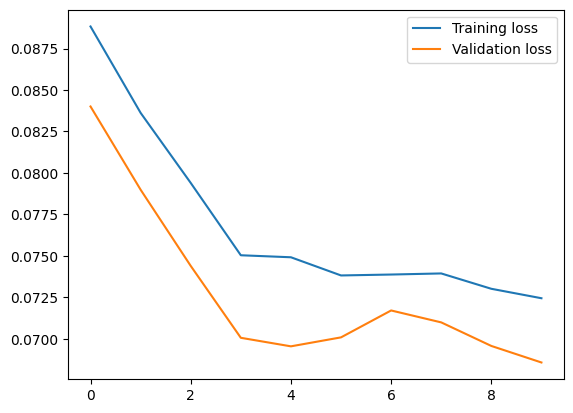

1/1 [==============================] - 8s 8s/step


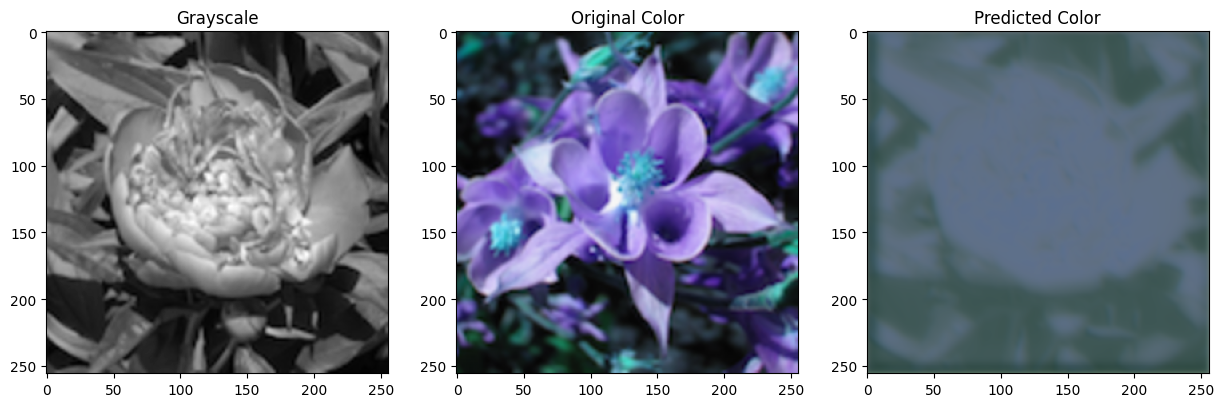

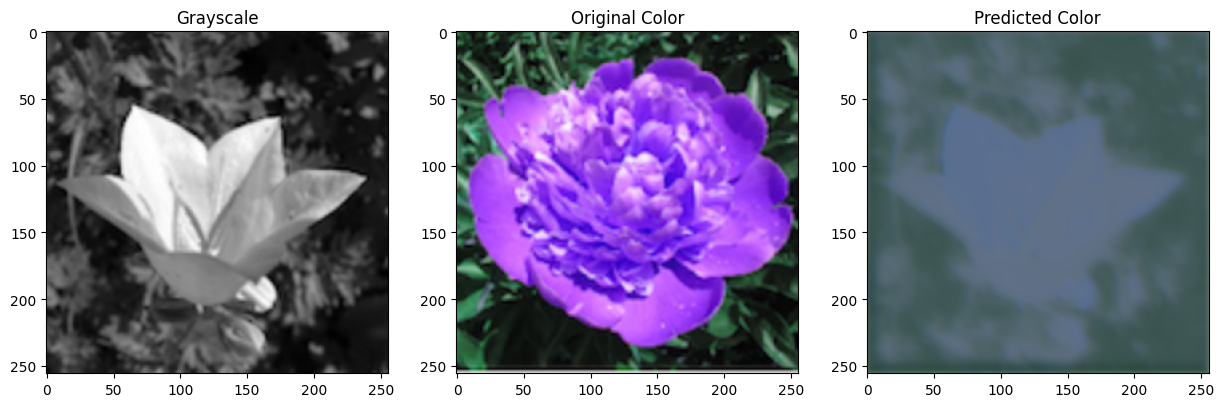

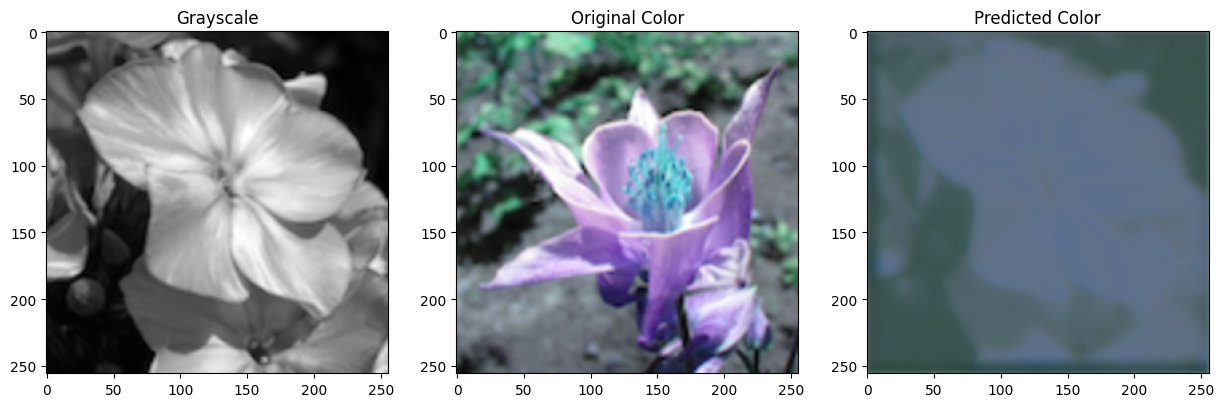

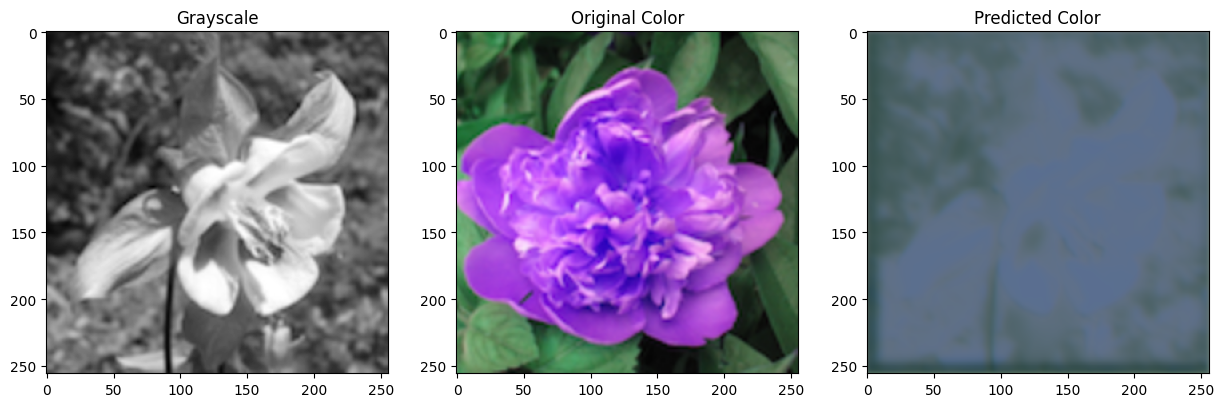

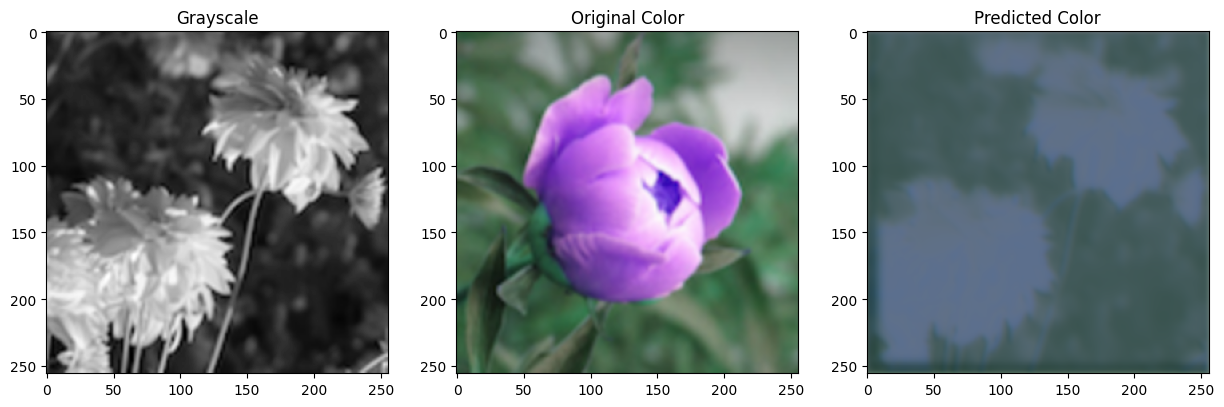

In [37]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Function to visualize results
def visualize_results(model, grayscale_images, color_images, num_images=5):
    predictions = model.predict(grayscale_images[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title('Grayscale')
        plt.imshow(grayscale_images[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title('Original Color')
        plt.imshow(color_images[i])

        plt.subplot(1, 3, 3)
        plt.title('Predicted Color')
        plt.imshow(predictions[i])

        plt.show()

# Visualize results
visualize_results(model, X_test, y_test)


1/1 [==============================] - 2s 2s/step


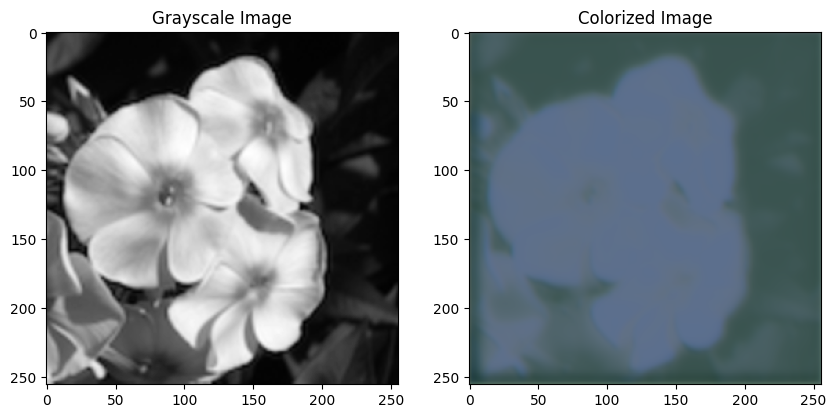

In [38]:
specific_image_path = os.path.join(train_dir, '0010.png')
specific_image = cv2.imread(specific_image_path)
specific_image = cv2.resize(specific_image, (256, 256))
specific_grayscale_image = cv2.cvtColor(specific_image, cv2.COLOR_BGR2GRAY)
specific_grayscale_image = np.expand_dims(specific_grayscale_image, axis=-1)  # Add channel dimension
specific_grayscale_image = specific_grayscale_image / 255.0  # Normalize to [0, 1]
specific_grayscale_image = np.expand_dims(specific_grayscale_image, axis=0)  # Add batch dimension
predicted_color_image = model.predict(specific_grayscale_image)
predicted_color_image = predicted_color_image[0]  # Remove batch dimension
import matplotlib.pyplot as plt

# Display the original grayscale image and the colorized image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Grayscale Image')
plt.imshow(specific_grayscale_image[0].squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Colorized Image')
plt.imshow(predicted_color_image)

plt.show()
